# Cyber Security Attacks Dataset Logistic Regression

### [Cyber Security Attacks Dataset](https://www.kaggle.com/datasets/teamincribo/cyber-security-attacks)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

## Citation

[1] Aashray Agur

[2] Uma Venugopal, https://www.kaggle.com/umavenugopal

## Install Modules

In [162]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Modules

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

## Load Dataset

In [164]:
df = pd.read_csv('cybersecurity_attacks.csv')

## Perform Essential Exploration & Data Cleaning

### Display the initial number of rows and columns.

In [165]:
df.shape

(40000, 25)

### Display the initial variable names and their associated data types.

In [166]:
df.dtypes

Timestamp                  object
Source IP Address          object
Destination IP Address     object
Source Port                 int64
Destination Port            int64
Protocol                   object
Packet Length               int64
Packet Type                object
Traffic Type               object
Payload Data               object
Malware Indicators         object
Anomaly Scores            float64
Alerts/Warnings            object
Attack Type                object
Attack Signature           object
Action Taken               object
Severity Level             object
User Information           object
Device Information         object
Network Segment            object
Geo-location Data          object
Proxy Information          object
Firewall Logs              object
IDS/IPS Alerts             object
Log Source                 object
dtype: object

### Create target variable.

In [167]:
df['Malware Event'] = np.where(df['Malware Indicators'].fillna('') == 'IoC Detected', 1, 0)

### Display the number of missing values for each column, remove the missing values and create a clean copy of the dataset.

In [168]:
df.isna().sum()

Timestamp                     0
Source IP Address             0
Destination IP Address        0
Source Port                   0
Destination Port              0
Protocol                      0
Packet Length                 0
Packet Type                   0
Traffic Type                  0
Payload Data                  0
Malware Indicators        20000
Anomaly Scores                0
Alerts/Warnings           20067
Attack Type                   0
Attack Signature              0
Action Taken                  0
Severity Level                0
User Information              0
Device Information            0
Network Segment               0
Geo-location Data             0
Proxy Information         19851
Firewall Logs             19961
IDS/IPS Alerts            20050
Log Source                    0
Malware Event                 0
dtype: int64

In [169]:
df_clean = df.dropna(subset=[col for col in df.columns if col != 'Malware Indicators']).copy()

In [170]:
df_clean.isna().sum()

Timestamp                    0
Source IP Address            0
Destination IP Address       0
Source Port                  0
Destination Port             0
Protocol                     0
Packet Length                0
Packet Type                  0
Traffic Type                 0
Payload Data                 0
Malware Indicators        1214
Anomaly Scores               0
Alerts/Warnings              0
Attack Type                  0
Attack Signature             0
Action Taken                 0
Severity Level               0
User Information             0
Device Information           0
Network Segment              0
Geo-location Data            0
Proxy Information            0
Firewall Logs                0
IDS/IPS Alerts               0
Log Source                   0
Malware Event                0
dtype: int64

### Display the number of unique values for each column after removing missing data and before initial exploration.

In [171]:
df_clean.nunique()

Timestamp                 2451
Source IP Address         2451
Destination IP Address    2451
Source Port               2402
Destination Port          2393
Protocol                     3
Packet Length             1148
Packet Type                  2
Traffic Type                 3
Payload Data              2451
Malware Indicators           1
Anomaly Scores            2159
Alerts/Warnings              1
Attack Type                  3
Attack Signature             2
Action Taken                 3
Severity Level               3
User Information          2418
Device Information        2240
Network Segment              3
Geo-location Data         2157
Proxy Information         2451
Firewall Logs                1
IDS/IPS Alerts               1
Log Source                   2
Malware Event                2
dtype: int64

### Display the number of unique values for the categorical variables after removing missing data and before initial exploration.

In [172]:
df_clean.select_dtypes(exclude='number').nunique()

Timestamp                 2451
Source IP Address         2451
Destination IP Address    2451
Protocol                     3
Packet Type                  2
Traffic Type                 3
Payload Data              2451
Malware Indicators           1
Alerts/Warnings              1
Attack Type                  3
Attack Signature             2
Action Taken                 3
Severity Level               3
User Information          2418
Device Information        2240
Network Segment              3
Geo-location Data         2157
Proxy Information         2451
Firewall Logs                1
IDS/IPS Alerts               1
Log Source                   2
dtype: int64

### Display the number of unique values for the continuous variables after removing missing data and before initial exploration.

In [173]:
df_clean.select_dtypes(include='number').nunique()

Source Port         2402
Destination Port    2393
Packet Length       1148
Anomaly Scores      2159
Malware Event          2
dtype: int64

### Drop specific features not to be used in the model.

In [174]:
df_clean = df_clean.drop(columns=['Malware Indicators'])

## Feature Engineering

### Select categories where there are 3 or less unique values and make them continuous.

In [175]:
cat_cols = [col for col in df_clean.columns if df_clean[col].nunique() <= 3 and col != 'Malware Event']

In [176]:
cat_features = df_clean[cat_cols]. \
                        apply(lambda x: x.astype('category'). \
                        cat.codes)

In [177]:
numeric_features = df_clean.select_dtypes('number').copy()

In [178]:
df_clean_features = pd.concat([numeric_features, 
                               cat_features], 
                               axis=1)

### Drop target from the features.

In [179]:
df_clean_features = df_clean_features.drop(columns=['Malware Event'])

## Data Standardization

### Examine raw numeric features magnitude and scale.

The actual values in the boxplot represent the distributions of the penguin dataset’s numeric features: bill length (mm), bill depth (mm), flipper length (mm), and body mass (g). The plot shows that body mass is on a much larger scale than the other features, indicating that its values are much higher (in grams) compared to the millimeter measurements of the other features, which is important for understanding feature scaling and the need for standardization in data analysis.

In [180]:
df_clean.describe()

,Source Port,Destination Port,Packet Length,Anomaly Scores,Malware Event
count,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000
mean,33575.931457,33123.212974,783.713994,49.870718,0.504692
std,18736.604921,18500.018876,415.370562,28.901531,0.500080
min,1031.000000,1041.000000,64.000000,0.030000,0.000000
25%,17258.500000,17201.000000,422.500000,25.455000,0.000000
50%,33989.000000,33005.000000,789.000000,49.850000,1.000000
75%,50138.500000,49590.500000,1150.000000,74.800000,1.000000
max,65514.000000,65496.000000,1500.000000,99.980000,1.000000


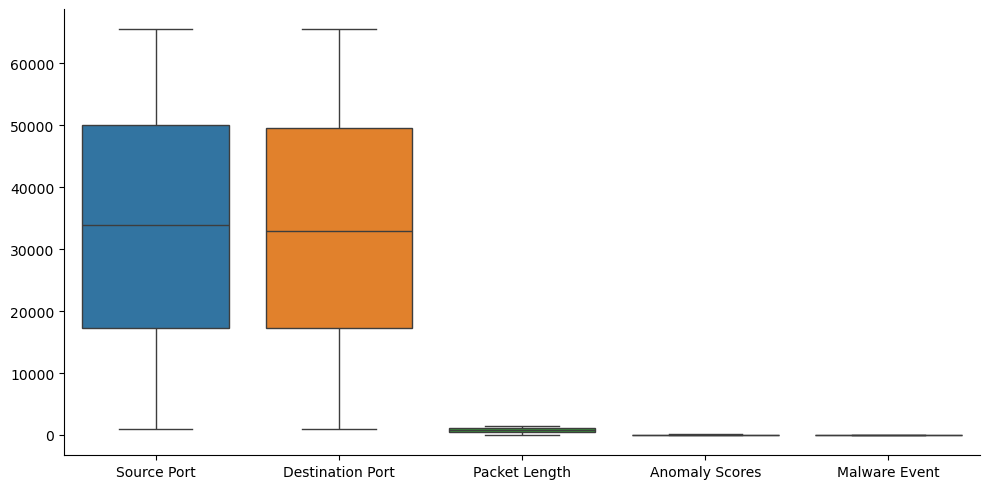

In [181]:
sns.catplot(data=df_clean, 
            kind='box', 
            aspect=2)
plt.show()

### Standardize the numeric features.

In [182]:
X = StandardScaler().fit_transform(df_clean_features)

### Examine standarized numeric features magnitude and scale.

After standardization, all numeric features (bill length, bill depth, flipper length, and body mass) have similar distributions centered around zero with comparable spread, indicating that differences in scale have been removed and the features are now suitable for clustering and other analyses that assume equal variance.

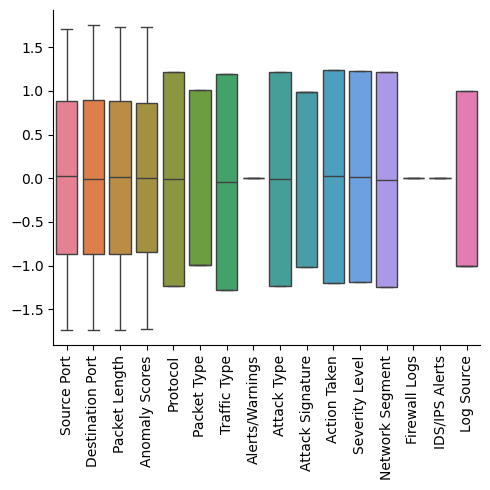

In [183]:
sns.catplot(data=pd.DataFrame(X, 
                              columns=df_clean_features.columns), 
                              kind='box')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Fit Pre-Feature Selection Logistic Regression Model

### Create the target variable.

In [184]:
y = df_clean['Malware Event']

### Train-test split the data.

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

### Fit the model.

In [186]:
lr = LogisticRegression(max_iter=1000)

In [187]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Review accuracy on the test set.

In [188]:
test_accuracy = lr.score(X_test, y_test)

In [189]:
print(f'Test Accuracy: {test_accuracy:.3f}')

Test Accuracy: 0.503


### Review precision, recall and the F1 score.

In [190]:
y_pred = lr.predict(X_test)

In [191]:
precision = precision_score(y_test, y_pred)

In [192]:
recall = recall_score(y_test, y_pred)

In [193]:
f1 = f1_score(y_test, y_pred)

In [194]:
print(f'Precision: {precision:.3f}')

Precision: 0.488


In [195]:
print(f'Recall: {recall:.3f}')

Recall: 0.603


In [196]:
print(f'F1 Score: {f1:.3f}')

F1 Score: 0.540


### Review the target to ensure the data is balanced.

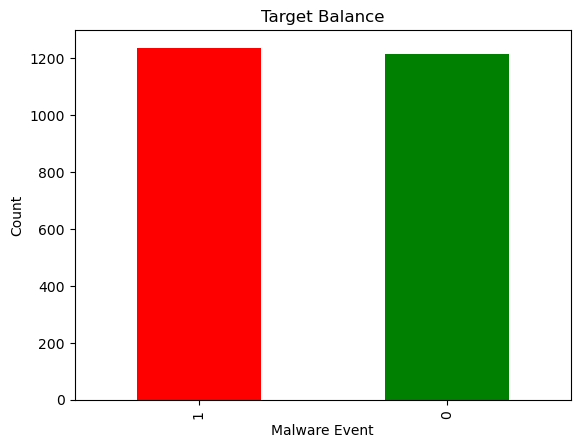

In [197]:
df_clean['Malware Event']. \
        value_counts(). \
        plot(kind='bar', 
             color=['red', 'green'])
plt.title('Target Balance')
plt.xlabel('Malware Event')
plt.ylabel('Count')
plt.show()

### Review the feature importance of each model input.

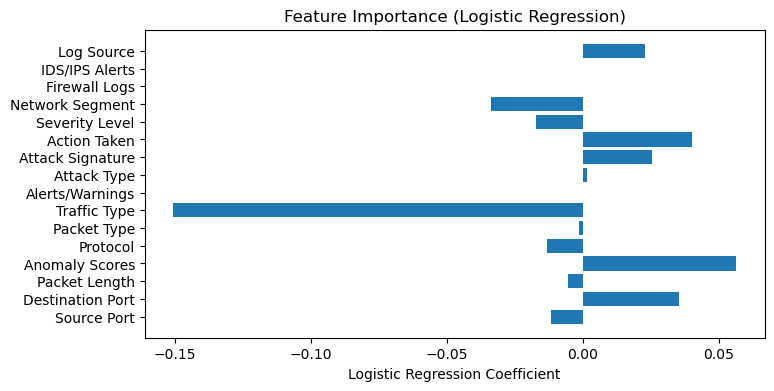

In [198]:
importances = lr.coef_[0]
feature_names = df_clean_features.columns
plt.figure(figsize=(8,4))
plt.barh(feature_names, importances)
plt.xlabel('Logistic Regression Coefficient')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

## Feature Selection

### Identify features we will use in our model.

In [199]:
selected_features = [
    'Traffic Type',
    'Anomaly Scores',
    'Action Taken',
    'Destination Port',
    'Network Segment',
    'Attack Signature']

### Get indices of selected features in `df_clean_features`.

### Create new model with selected features.

In [200]:
selected_indices = [df_clean_features.columns.get_loc(col) for col in selected_features]

### Subset X to only selected features.

In [201]:
X_selected = X[:, selected_indices]

## Fit Feature Selection Logistic Regression Model

### Train-test split the data with the selected features.

In [202]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

### Fit logistic regression model with the selected features.


In [203]:
lr_selected = LogisticRegression(max_iter=1000)

In [204]:
lr_selected.fit(X_train_sel, y_train_sel)

LogisticRegression(max_iter=1000)

### Review accuracy on the test set with the selected features.

In [205]:
test_accuracy_sel = lr_selected.score(X_test_sel, y_test_sel)

In [206]:
print(f'Test Accuracy (Selected Features): {test_accuracy_sel:.3f}')

Test Accuracy (Selected Features): 0.505


### Review precision, recall and the F1 score with the selected features.

In [207]:
y_pred_sel = lr_selected.predict(X_test_sel)

In [208]:
precision_sel = precision_score(y_test_sel, y_pred_sel)

In [209]:
recall_sel = recall_score(y_test_sel, y_pred_sel)

In [210]:
f1_sel = f1_score(y_test_sel, y_pred_sel)

In [211]:
print(f'Precision (Selected Features): {precision_sel:.3f}')

Precision (Selected Features): 0.489


In [212]:
print(f'Recall (Selected Features): {recall_sel:.3f}')

Recall (Selected Features): 0.586


In [213]:
print(f'F1 Score (Selected Features): {f1_sel:.3f}')

F1 Score (Selected Features): 0.534
